# Deeper Neural Networks with nn.ModuleList(): Multi-Class Spiral Classification

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib.colors import ListedColormap

# Set random seed for reproducibility
torch.manual_seed(42)

# GPU/CPU device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


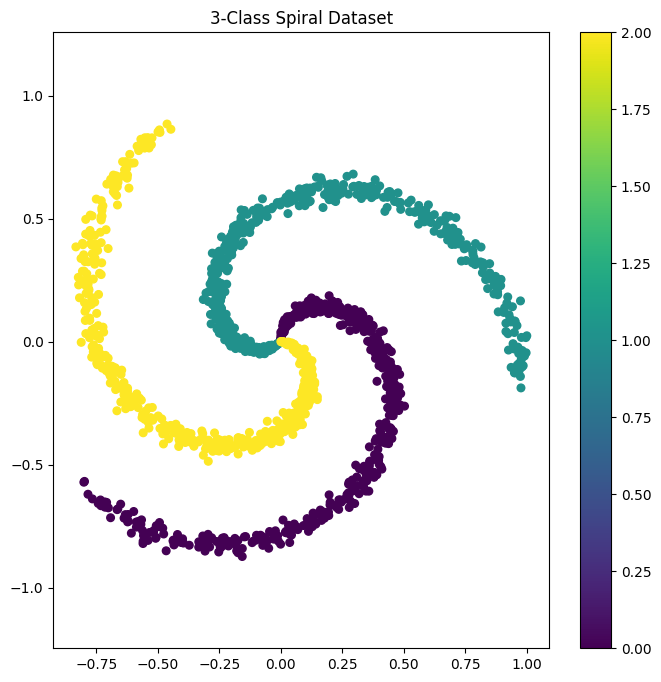

In [17]:
# Generate spiral dataset for multi-class classification (FIXED)
class SpiralDataset(Dataset):
    def __init__(self, n_points=500, n_classes=3, noise=0.2):
        self.n_points = n_points
        self.n_classes = n_classes
        
        # Create empty arrays for data
        self.x = torch.zeros((n_points*n_classes, 2))
        self.y = torch.zeros(n_points*n_classes, dtype=torch.long)
        
        # Generate spiral data
        for i in range(n_classes):
            ix = range(n_points*i, n_points*(i+1))
            r = np.linspace(0.0, 1, n_points)  # radius
            t = np.linspace(i*4, (i+1)*4, n_points) + noise * np.random.randn(n_points)  # theta
            # Fix: Specify dtype=torch.float32 to match self.x
            self.x[ix] = torch.tensor(np.c_[r*np.sin(t), r*np.cos(t)], dtype=torch.float32)
            self.y[ix] = i
    
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def plot(self, title="Spiral Dataset"):
        plt.figure(figsize=(8, 8))
        plt.scatter(self.x[:, 0], self.x[:, 1], c=self.y, cmap='viridis', s=30)
        plt.title(title)
        plt.axis('equal')
        plt.colorbar()
        plt.show()

# Create dataset
spiral_data = SpiralDataset(n_points=500, n_classes=3, noise=0.1)
spiral_data.plot("3-Class Spiral Dataset")

In [18]:
# Deep Neural Network with nn.ModuleList for flexible architecture
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, dropout_prob=0.0):
        super(DeepNeuralNetwork, self).__init__()
        
        # Input dimension -> first hidden layer
        layers = [nn.Linear(input_size, hidden_layers[0])]
        
        # Hidden layers
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
        
        # Final hidden layer -> output
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        
        # Use ModuleList to store all layers
        self.layers = nn.ModuleList(layers)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        # Pass through all layers except last one
        for i in range(len(self.layers)-1):
            x = torch.relu(self.layers[i](x))
            x = self.dropout(x)  # Apply dropout after activation
            
        # Output layer (no activation or dropout for final layer)
        x = self.layers[-1](x)
        return x

# Create models with different depths using ModuleList
model_shallow = DeepNeuralNetwork(
    input_size=2,
    hidden_layers=[100],  # 1 hidden layer
    output_size=3,
    dropout_prob=0.0
).to(device)

model_medium = DeepNeuralNetwork(
    input_size=2,
    hidden_layers=[100, 100],  # 2 hidden layers
    output_size=3, 
    dropout_prob=0.2
).to(device)

model_deep = DeepNeuralNetwork(
    input_size=2, 
    hidden_layers=[100, 100, 100, 50],  # 4 hidden layers
    output_size=3,
    dropout_prob=0.2
).to(device)

# Print model architectures
print("Shallow Model Architecture:")
print(model_shallow)
print("\nMedium Model Architecture:")
print(model_medium)
print("\nDeep Model Architecture:")
print(model_deep)

Shallow Model Architecture:
DeepNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

Medium Model Architecture:
DeepNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Deep Model Architecture:
DeepNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)


In [19]:
# Function to train models
def train_model(model, data, epochs=500, lr=0.01):
    # Move data to device
    x = data.x.to(device)
    y = data.y.to(device)
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Track losses and accuracy
    losses = []
    accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        # Set to training mode
        model.train()
        
        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record loss
        losses.append(loss.item())
        
        # Calculate accuracy
        model.eval()
        with torch.no_grad():
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y).sum().item() / len(y)
            accuracies.append(accuracy)
        
        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    
    return losses, accuracies

# Train all models
print("Training Shallow Model...")
shallow_losses, shallow_acc = train_model(model_shallow, spiral_data, epochs=500)

print("\nTraining Medium Model...")
medium_losses, medium_acc = train_model(model_medium, spiral_data, epochs=500)

print("\nTraining Deep Model...")
deep_losses, deep_acc = train_model(model_deep, spiral_data, epochs=500)

Training Shallow Model...
Epoch 100/500, Loss: 0.1808, Accuracy: 0.9507
Epoch 200/500, Loss: 0.0740, Accuracy: 0.9913
Epoch 300/500, Loss: 0.0459, Accuracy: 0.9960
Epoch 400/500, Loss: 0.0340, Accuracy: 0.9973
Epoch 500/500, Loss: 0.0274, Accuracy: 0.9980

Training Medium Model...
Epoch 100/500, Loss: 0.0445, Accuracy: 0.9853
Epoch 200/500, Loss: 0.0249, Accuracy: 0.9907
Epoch 300/500, Loss: 0.0188, Accuracy: 0.9940
Epoch 400/500, Loss: 0.0140, Accuracy: 0.9933
Epoch 500/500, Loss: 0.0128, Accuracy: 0.9967

Training Deep Model...
Epoch 100/500, Loss: 0.0229, Accuracy: 0.9927
Epoch 200/500, Loss: 0.0173, Accuracy: 0.9927
Epoch 300/500, Loss: 0.0106, Accuracy: 0.9967
Epoch 400/500, Loss: 0.0109, Accuracy: 0.9980
Epoch 500/500, Loss: 0.0089, Accuracy: 0.9967


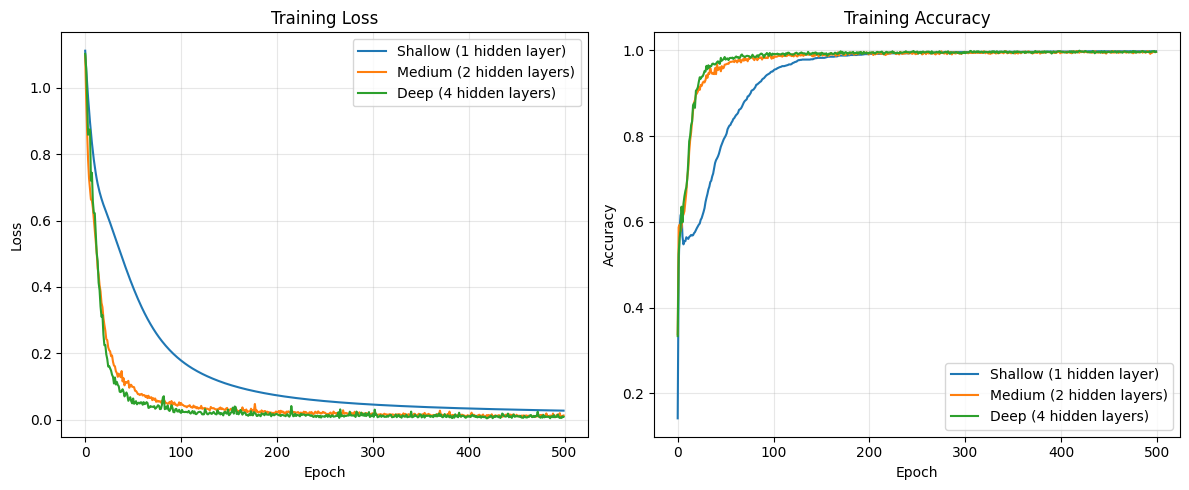

Final Training Accuracies:
Shallow Model: 0.9980
Medium Model:  0.9967
Deep Model:    0.9967


In [20]:
# Visualize training curves
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(shallow_losses, label='Shallow (1 hidden layer)')
plt.plot(medium_losses, label='Medium (2 hidden layers)')
plt.plot(deep_losses, label='Deep (4 hidden layers)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(shallow_acc, label='Shallow (1 hidden layer)')
plt.plot(medium_acc, label='Medium (2 hidden layers)')
plt.plot(deep_acc, label='Deep (4 hidden layers)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final accuracies
print(f"Final Training Accuracies:")
print(f"Shallow Model: {shallow_acc[-1]:.4f}")
print(f"Medium Model:  {medium_acc[-1]:.4f}")
print(f"Deep Model:    {deep_acc[-1]:.4f}")

/tmp/ipykernel_60945/2867512399.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


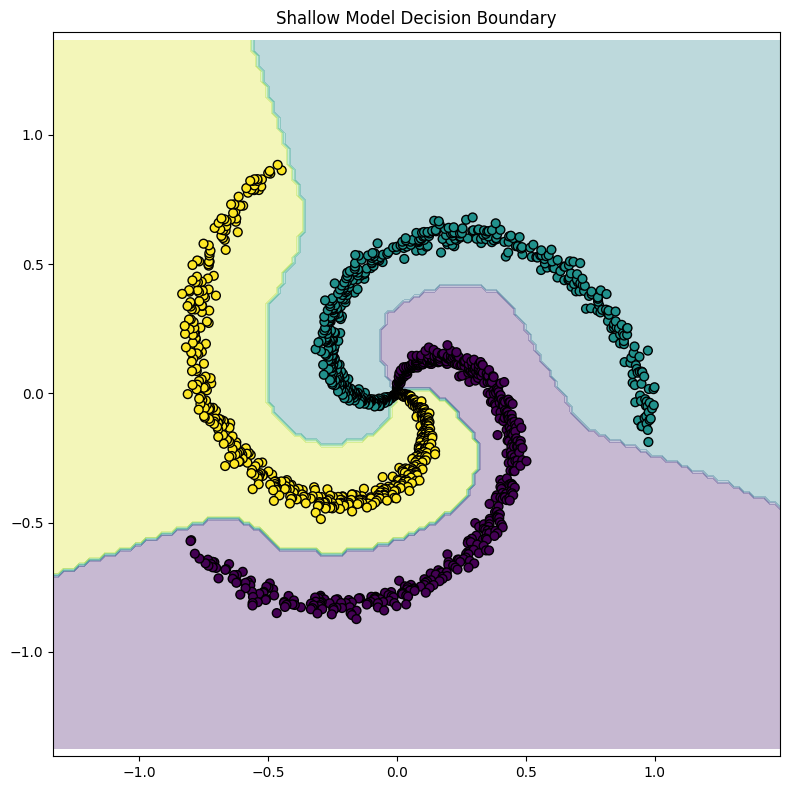

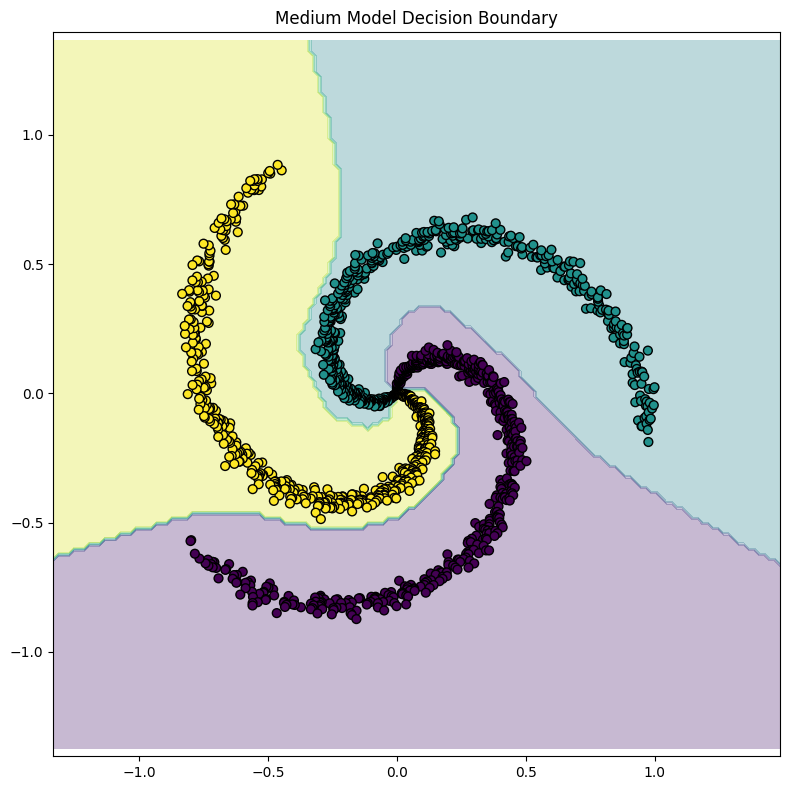

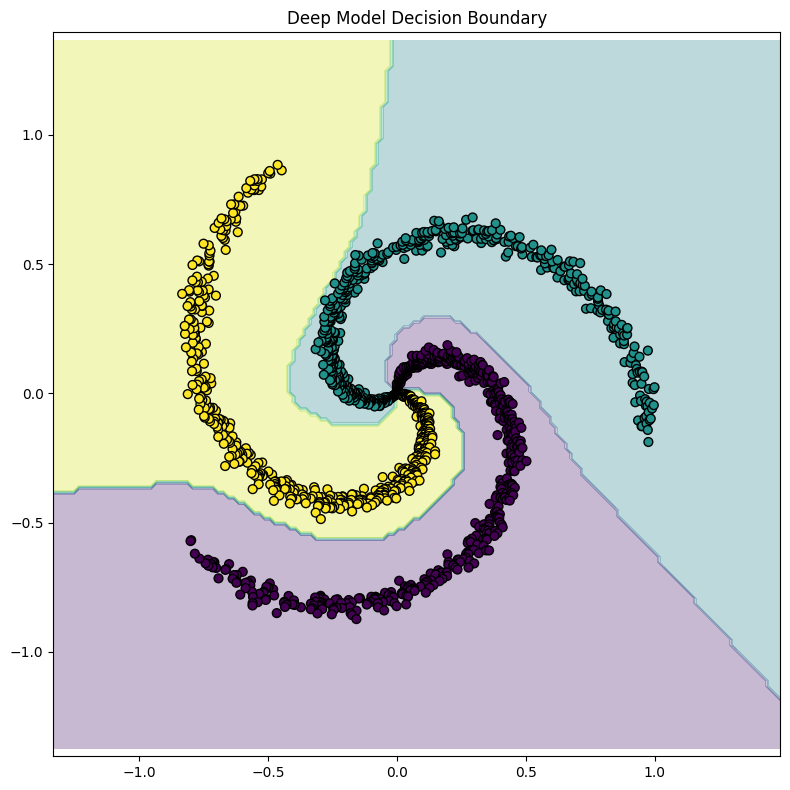


Key Insights:
• Deeper networks can model more complex decision boundaries
• nn.ModuleList allows flexible construction of networks with varying depths
• Deeper networks may learn more effectively on spiral data due to its non-linear nature
• Regularization becomes more important as network depth increases


In [21]:
# Function to plot decision boundaries
def plot_decision_boundary(model, data, title):
    model.eval()  # Set to evaluation mode
    
    # Define mesh grid for plotting
    h = 0.02  # Step size
    x_min, x_max = data.x[:, 0].min() - 0.5, data.x[:, 0].max() + 0.5
    y_min, y_max = data.x[:, 1].min() - 0.5, data.x[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Get predictions for all grid points
    grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.no_grad():
        Z = model(grid_points)
        _, Z = torch.max(Z, 1)
        Z = Z.cpu().numpy()
    
    # Reshape predictions to match grid shape
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and data points
    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(data.x[:, 0], data.x[:, 1], c=data.y, cmap='viridis', edgecolors='k', s=40)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Plot decision boundaries for all models
plot_decision_boundary(model_shallow, spiral_data, "Shallow Model Decision Boundary")
plot_decision_boundary(model_medium, spiral_data, "Medium Model Decision Boundary")
plot_decision_boundary(model_deep, spiral_data, "Deep Model Decision Boundary")

# Summarize findings
print("\nKey Insights:")
print("• Deeper networks can model more complex decision boundaries")
print("• nn.ModuleList allows flexible construction of networks with varying depths")
print("• Deeper networks may learn more effectively on spiral data due to its non-linear nature")
print("• Regularization becomes more important as network depth increases")